In [20]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)


In [21]:
matches = pd.read_csv("data/epl_matches_2024_2026.csv", parse_dates=["Date"])

# keep only what's needed to build *pre-match* features
cols = [
    "Date","HomeTeam","AwayTeam","FTR",           # identifiers + target
    "FTHG","FTAG",                                # final goals (for rolling history only)
    "HST","AST",                                  # shots on target (for rolling history only)
    "B365H","B365D","B365A"                       # pre-match odds
]
df = matches[cols].copy()

# types
df["Date"] = pd.to_datetime(df["Date"])
for c in ["FTHG","FTAG","HST","AST","B365H","B365D","B365A"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# chronological order
df = df.sort_values("Date").reset_index(drop=True)
df.head()


/var/folders/_n/28tv1klj3wl7n9w01h3vtfx80000gn/T/ipykernel_22563/2548075501.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  matches = pd.read_csv("data/epl_matches_2024_2026.csv", parse_dates=["Date"])


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HST,AST,B365H,B365D,B365A
0,2024-08-16,Man United,Fulham,H,1,0,5,2,1.60,4.20,5.25
1,2024-08-17,Ipswich,Liverpool,A,0,2,2,5,8.50,5.50,1.33
2,2024-08-17,Arsenal,Wolves,H,2,0,6,3,1.18,7.50,13.00
3,2024-08-17,Everton,Brighton,A,0,3,1,5,2.63,3.30,2.63
4,2024-08-17,Newcastle,Southampton,H,1,0,1,4,1.36,5.25,8.00


In [22]:
ROLL_N = 5

# home team form (from home perspective)
df["HomeGoalsFor"]      = df.groupby("HomeTeam")["FTHG"].shift().rolling(ROLL_N).mean()
df["HomeGoalsAgainst"]  = df.groupby("HomeTeam")["FTAG"].shift().rolling(ROLL_N).mean()
df["HomeShotsFor"]      = df.groupby("HomeTeam")["HST"].shift().rolling(ROLL_N).mean()
df["HomeShotsAgainst"]  = df.groupby("HomeTeam")["AST"].shift().rolling(ROLL_N).mean()

# away team form (from away perspective)
df["AwayGoalsFor"]      = df.groupby("AwayTeam")["FTAG"].shift().rolling(ROLL_N).mean()
df["AwayGoalsAgainst"]  = df.groupby("AwayTeam")["FTHG"].shift().rolling(ROLL_N).mean()
df["AwayShotsFor"]      = df.groupby("AwayTeam")["AST"].shift().rolling(ROLL_N).mean()
df["AwayShotsAgainst"]  = df.groupby("AwayTeam")["HST"].shift().rolling(ROLL_N).mean()

# keep rows where we have complete rolling history + odds + target
need = [
    "HomeGoalsFor","HomeGoalsAgainst","AwayGoalsFor","AwayGoalsAgainst",
    "HomeShotsFor","HomeShotsAgainst","AwayShotsFor","AwayShotsAgainst",
    "B365H","B365D","B365A","FTR"
]
df_model = df.dropna(subset=need).reset_index(drop=True)
df_model.head()


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HST,AST,B365H,B365D,B365A,HomeGoalsFor,HomeGoalsAgainst,HomeShotsFor,HomeShotsAgainst,AwayGoalsFor,AwayGoalsAgainst,AwayShotsFor,AwayShotsAgainst
0,2024-08-31,Brentford,Southampton,H,3,1,7,6,1.75,3.90,4.33,1.0,1.4,4.2,5.0,0.8,1.0,3.4,3.6
1,2024-08-31,Arsenal,Brighton,D,1,1,7,4,1.33,5.50,8.50,1.2,1.2,4.8,4.2,1.0,0.8,3.8,3.2
2,2024-08-31,Everton,Bournemouth,A,2,3,8,7,2.75,3.40,2.55,1.0,1.6,3.4,4.4,1.2,0.6,4.0,3.6
3,2024-09-01,Chelsea,Crystal Palace,D,1,1,7,3,1.60,4.33,5.00,1.0,1.6,3.6,4.4,1.4,0.8,4.8,3.6
4,2024-09-01,Newcastle,Tottenham,H,2,1,3,6,2.50,4.00,2.50,1.0,1.2,3.2,4.6,1.2,1.0,5.2,3.6


In [23]:
from sklearn.model_selection import train_test_split

features = [
    "HomeTeam","AwayTeam",                         # categorical (team identity)
    "HomeGoalsFor","HomeGoalsAgainst",
    "AwayGoalsFor","AwayGoalsAgainst",
    "HomeShotsFor","HomeShotsAgainst",
    "AwayShotsFor","AwayShotsAgainst",
    "B365H","B365D","B365A"                        # pre-match odds
]
X_raw = df_model[features].copy()
y     = df_model["FTR"].copy()                     # 'H'/'D'/'A'

# time-based split: last 15% as test
split_idx = int(len(df_model)*0.85)
X_train, X_test = X_raw.iloc[:split_idx], X_raw.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape


((323, 13), (58, 13))

Accuracy: 0.5517241379310345
              precision    recall  f1-score   support

           A      0.550     0.500     0.524        22
           D      0.333     0.083     0.133        12
           H      0.571     0.833     0.678        24

    accuracy                          0.552        58
   macro avg      0.485     0.472     0.445        58
weighted avg      0.514     0.552     0.507        58



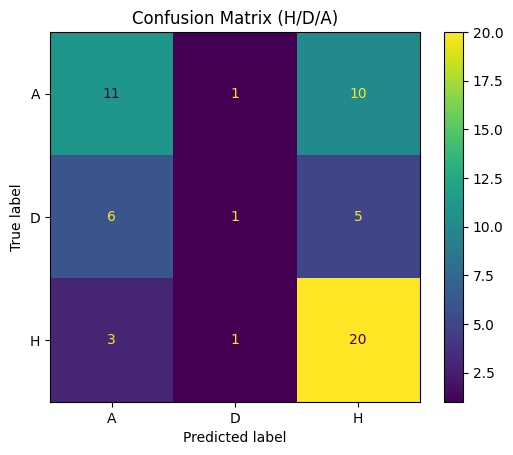

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cat_cols = ["HomeTeam","AwayTeam"]
num_cols = [c for c in X_raw.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample"
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", clf)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (H/D/A)")
plt.show()


In [25]:
def latest_team_row(team_name: str, side: str = "home"):
    """
    side: 'home' -> pull cols HomeGoalsFor/Against, HomeShotsFor/Against
          'away' -> pull cols AwayGoalsFor/Against, AwayShotsFor/Against
    Returns a dict of rolling features for that side using the latest row found.
    """
    if side == "home":
        mask = df_model["HomeTeam"].eq(team_name)
        cols = ["HomeGoalsFor","HomeGoalsAgainst","HomeShotsFor","HomeShotsAgainst"]
    else:
        mask = df_model["AwayTeam"].eq(team_name)
        cols = ["AwayGoalsFor","AwayGoalsAgainst","AwayShotsFor","AwayShotsAgainst"]

    subset = df_model.loc[mask, cols]
    if subset.empty:
        raise ValueError(f"No history found for team '{team_name}' as {side}")
    return subset.iloc[-1].to_dict()

def predict_fixture(home_team: str, away_team: str, b365h: float, b365d: float, b365a: float):
    home_form = latest_team_row(home_team, "home")
    away_form = latest_team_row(away_team, "away")

    row = {
        "HomeTeam": home_team,
        "AwayTeam": away_team,
        "B365H": b365h, "B365D": b365d, "B365A": b365a,
        "HomeGoalsFor": home_form["HomeGoalsFor"],
        "HomeGoalsAgainst": home_form["HomeGoalsAgainst"],
        "HomeShotsFor": home_form["HomeShotsFor"],
        "HomeShotsAgainst": home_form["HomeShotsAgainst"],
        "AwayGoalsFor": away_form["AwayGoalsFor"],
        "AwayGoalsAgainst": away_form["AwayGoalsAgainst"],
        "AwayShotsFor": away_form["AwayShotsFor"],
        "AwayShotsAgainst": away_form["AwayShotsAgainst"],
    }
    X_one = pd.DataFrame([row], columns=features)
    pred  = pipe.predict(X_one)[0]
    proba = pipe.predict_proba(X_one)[0]
    return pred, dict(zip(pipe.classes_, np.round(proba, 3))), X_one

# example usage (plug in *current* odds before you run)
# pred, probs, row = predict_fixture("Man City", "Arsenal", b365h=1.90, b365d=3.80, b365a=4.20)
# print("Prediction:", pred)
# print("Probabilities:", probs)
# row


In [ ]:
pred, probs, row = predict_fixture(
    home_team="Arsenal",
    away_team="Man City",
    b365h=1.85,   # Arsenal win
    b365d=3.90,   # Draw
    b365a=3.80    # Man City win
)

print("Predicted result:", pred)
print("Probabilities:", probs)
# Added in sample data for Arsenal vs Man City match tommorow.


Predicted result: H
Probabilities: {'A': np.float64(0.235), 'D': np.float64(0.228), 'H': np.float64(0.538)}
